# Clustering with PyMC3: Simple 2 clusters

In [1]:
import warnings
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as T
import pymc3 as pm

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

/Users/42155/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Clusters are generated as follows:

1. For each sample, choose cluster 1 with probability $p$, else choose cluster 2.
2. Draw a random sample from a Normal distribution with parameters $\mu_i, \sigma_i$ with $i$ from the previous step.

1000 samples in total from 2 clusters. data: (1000,)


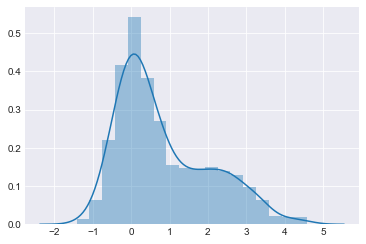

In [2]:
np.random.seed(42)

n = 1000 # Total number of samples
k = 2  # Number of clusters
p_real = 0.6  # Probability of choosing cluster 1
mus_real = np.array([0., 2.])  #  Mu of clusters
sigmas_real = np.array([0.5, 1.])  # Sigma of clusters
clusters = np.random.choice(k, size=n, p=[p_real, 1-p_real])
data = np.random.normal(mus_real[clusters], sigmas_real[clusters], size=n)

print('{} samples in total from {} clusters. data: {}'.format(n, k, data.shape))
sns.distplot(data)
plt.show()

In [3]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)  # Uninformed prior for p
    p2 = 1 - p1
    p = T.stack([p1, p2])
    # Categorical needs to have the same lenght as the data.
    # If we leave out the lenght it won't converge.
    # If the length is not equal to the data, "observations" will complain
    cluster = pm.Categorical('cluster', p, shape=n, testval=np.random.randint(0, 2, n))
    # Prior on cluster standard diviations
    sigmas = pm.Gamma('sigmas', alpha=np.array([2, 2]), beta=np.array([1, 1]), shape=k)
    # Prior on cluster means
    mus = pm.Normal('mus', mu=np.array([0, 0]), sd=np.array([10, 10]), shape=k)
    # Cluster choice is a deterministic choice, so determinstically pick 1 mu and sigma
    mu_i = pm.Deterministic('mu_i', mus[cluster])
    sigma_i = pm.Deterministic('sigma_i', sigmas[cluster])
    # and to combine it with the observations:
    observations = pm.Normal('observations', mu=mu_i, sd=sigma_i, observed=data)

print('Prior cluster assignment, with p: {}'.format(p1.tag.test_value))
print('Random cluster shape: {}, test values: {}'.format(cluster.dshape, cluster.tag.test_value[:10]))
print('Assigned mu: ', mu_i.tag.test_value[:10])
print('Assigned sigma: ', sigma_i.tag.test_value[:10])

Prior cluster assignment, with p: 0.5
Random cluster shape: (1000,), test values: [0 0 0 0 0 0 1 1 0 1]
Assigned mu:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Assigned sigma:  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [4]:
# Run inference
niter = 10000
with model:
    step1 = pm.NUTS(vars=[p, sigmas, mus])  # For continous variables
    step2 = pm.ElemwiseCategorical(vars=[cluster])  # For Categorical variables
    trace = pm.sample(niter, step=[step1, step2], random_seed=42, progressbar=True)

100%|██████████| 10500/10500 [02:50<00:00, 61.62it/s]


trace:  (10000,)


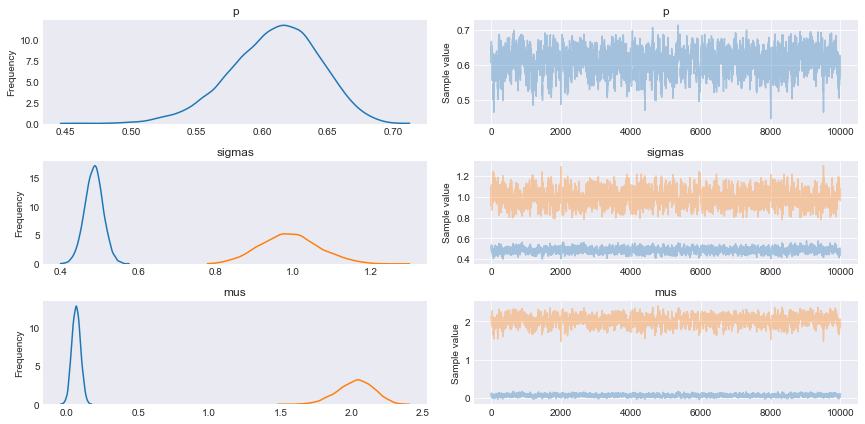

In [5]:
print('trace: ', trace['p'].shape)
pm.traceplot(trace, varnames=['p', 'sigmas', 'mus'])
plt.show()

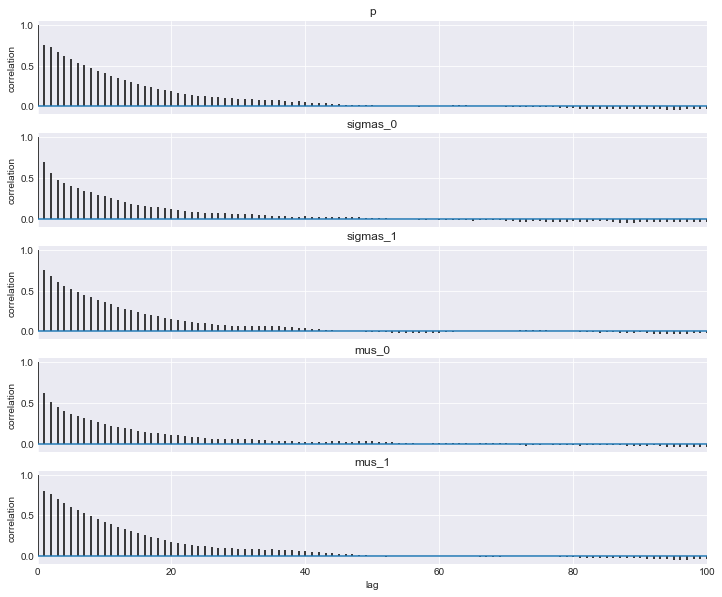

In [6]:
pm.autocorrplot(trace, varnames=['p', 'sigmas', 'mus'])
plt.show()

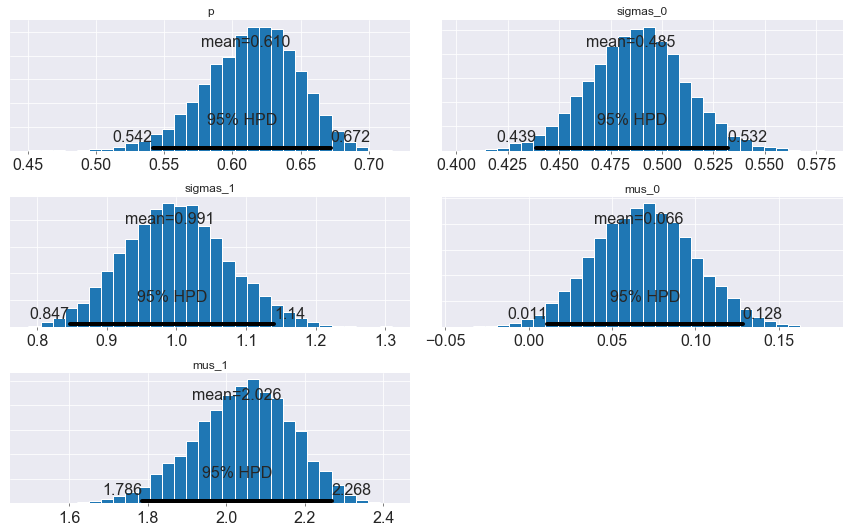

In [7]:
pm.plot_posterior(trace, varnames=['p', 'sigmas', 'mus'])
plt.show()

In [8]:
# Sample from the posterior
with model:
    # 1 sample will correspond to the 1000 observations because of the categorical of lenght `n`
    posterior_trace = pm.sample_ppc(trace, samples=1, random_seed=42)

100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


Samples from posterior:  (1, 1000)


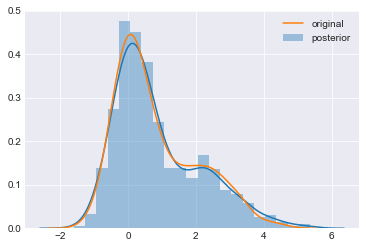

In [9]:
print('Samples from posterior: ', posterior_trace['observations'].shape)
sns.distplot(posterior_trace['observations'], label='posterior')
sns.distplot(data, hist=False, label='original')
plt.show()